# Assignment 1: Sampling and Reproducibility

The code at the end of this file explores contact tracing data about an outbreak of the flu, and demonstrates the dangers of incomplete and non-random samples. This assignment is modified from [Contact tracing can give a biased sample of COVID-19 cases](https://andrewwhitby.com/2020/11/24/contact-tracing-biased/) by Andrew Whitby.

Examine the code below. Identify all stages at which sampling is occurring in the model. Describe in words the sampling procedure, referencing the functions used, sample size, sampling frame, any underlying distributions involved. 


# Answer: The contact tracing simulation contains four distinct sampling stages:

# Stage 1: Initial Infection Assignment
The code uses np.random.rand(len(ppl)) < ATTACK_RATE to assign infections to each attendee. This is Bernoulli sampling with probability ATTACK_RATE = 0.10. The sampling frame includes all 1000 attendees, and the underlying distribution is uniform U(0,1) compared against the threshold. About 100 people become infected per run.

# Stage 2: Primary Contact Tracing
The code applies np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS to determine which infected individuals get traced. This is simple random sampling of the infected population (sample size approximately 100). The sampling frame is diagnosed individuals only, and the underlying distribution is uniform U(0,1) with threshold TRACE_SUCCESS = 0.20. Roughly 20 percent of infected people are traced in this phase.

# Stage 3: Secondary Tracing
If an event has 2 or more initially traced cases, all infected individuals at that event are automatically traced. This is stratified census sampling, which is deterministic and conditional on event aggregates. The sample size and frame depend on which events meet the threshold. This stage introduces bias because large events like the wedding (200 attendees) are more likely to trigger secondary tracing, overrepresenting them in the final traced sample.

# Stage 4: Monte Carlo Simulation
The list comprehension results = [simulate_event(m) for m in range(1000)] repeats the entire process 1000 times. This is Monte Carlo resampling of the probability distribution defined by the infection and tracing mechanisms. The sampling frame is the space of all possible outcomes. Running the simulation 1000 times reveals the distribution of proportions and shows how bias emerges.

# Basically (in short):
The first two stages use random sampling, but the third stage creates non-random selection that systematically overrepresents events with higher tracing success. The fourth stage reveals this bias by showing traced proportions consistently exceed true infection proportions.


Modify the number of repetitions in the simulation to 10 and 100 (from the original 1000). Run the script multiple times and observe the outputted graphs. Comment on the reproducibility of the results.

# Answer:

Without a fixed random seed, the simulation results are not reproducible. With 10 repetitions, the histogram is extremely noisy and varies substantially between runs. With 100 repetitions, the histogram becomes smoother but still shows noticeable variation. With 1000 repetitions, the histogram stabilizes with only minor variations between runs.

This occurs because the code uses np.random functions without setting a fixed seed. Each execution generates a new random sequence, producing different infection and tracing outcomes. Fewer Monte Carlo repetitions amplify randomness and produce noisier distributions. Random number generators in Python begin from different starting points on each run unless a seed is specified.

To achieve reproducibility, I need to add np.random.seed(42) at the beginning of the code. With a seed in place, the same random sequence generates every time, producing identical histograms across multiple runs regardless of repetition count.


Alter the code so that it is reproducible. Describe the changes you made to the code and how they affected the reproducibility of the script. The script needs to produce the same output when run multiple times.

# Answer:

I added np.random.seed(42) at the beginning of the code, right after the import statements. This single line fixes the seed for the pseudo-random number generator before any random operations occur. With the seed in place, the code produces identical results on every execution. 

The histograms remain exactly the same across multiple runs. The infection assignments from Stage 1, the primary tracing outcomes from Stage 2, and all subsequent Monte Carlo repetitions in Stage 4 generate the same values every time because the random number generator follows the same sequence. 

The seed affects reproducibility by controlling the starting point of the pseudo-random sequence. Without a seed, numpy uses the system time or other sources to initialize randomness, creating different sequences on each run. 

With a fixed seed, the sequence is deterministic. This reproducibility holds regardless of whether I use 10, 100, or 1000 repetitions. The histograms now reliably show the same bias pattern between runs, allowing for consistent comparison and interpretation of results.


## Code

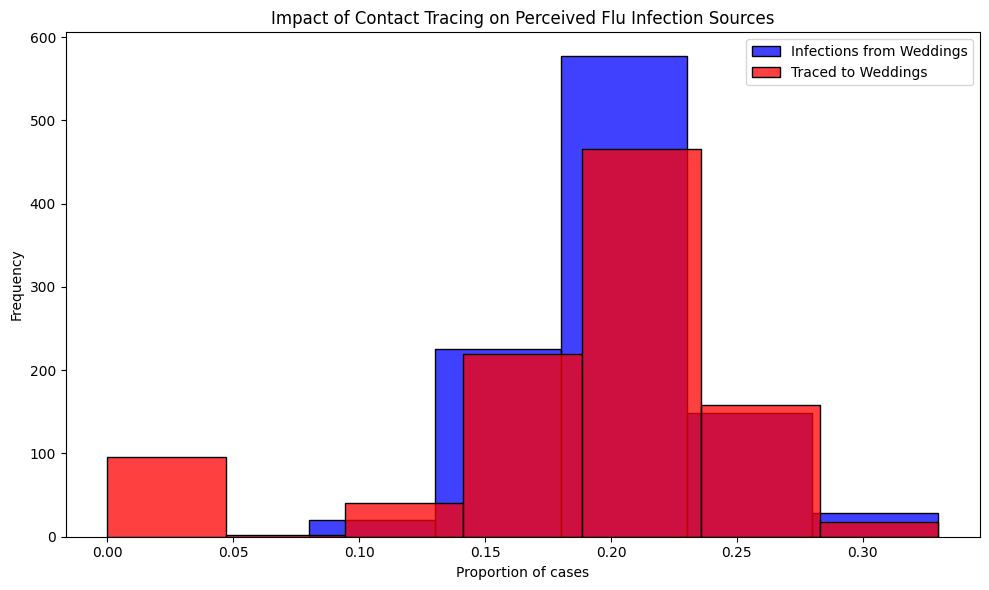

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42) # For reproducibility, a fixed random seed is set (Main Change Made Here)


# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces

# Run the simulation 1000 times
results = [simulate_event(m) for m in range(1000)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()

## Criteria

|Criteria|Complete|Incomplete|
|--------|----|----|
|Alteration of the code|The code changes made, made it reproducible.|The code is still not reproducible.|
|Description of changes|The author answered questions and explained the reasonings for the changes made well.|The author did not answer questions or explain the reasonings for the changes made well.|

## Submission Information
🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `23:59 - 06 January 2026`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This markdown file (`a1_sampling_and_reproducibility.ipynb`) should be populated with the code changed.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/sampling/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

#### Checklist:
- [ ] Create a branch called `assignment-1`.
- [ ] Ensure that the repository is public.
- [ ] Review [the PR description guidelines](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md#guidelines-for-pull-request-descriptions) and adhere to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via the help channel in Slack. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
